<a href="https://colab.research.google.com/github/torayeff/RoboCupHumanoid/blob/master/Sweaty1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RoboCupHumanoid Setup for Google Colab

In [10]:
# cleaning
!rm -rf data/
!rm -rf sweaty_1\ \(for\ comparing\)
!rm -rf *.csv *.py *.md *.jpg *.ipynb
!rm -rf sweaty_compare
!rm -rf automatic_labeling
!rm -rf pretrained_models

find: warning: Unix filenames usually don't contain slashes (though pathnames do).  That means that '-name ‘drive/’' will probably evaluate to false all the time on this system.  You might find the '-wholename' test more useful, or perhaps '-samefile'.  Alternatively, if you are using GNU grep, you could use 'find ... -print0 | grep -FzZ ‘drive/’'.
rm: refusing to remove '.' or '..' directory: skipping '.'
rm: cannot remove './drive/My Drive': Operation canceled
rm: cannot remove './drive/My Drive': Operation canceled


### Install Pytorch

In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q torch==1.0.0 torchvision

!pip uninstall Pillow
!pip install Pillow==5.3.0

### Clone RoboCupHumanoid

In [1]:
!git clone https://github.com/torayeff/RoboCupHumanoid.git
!mv RoboCupHumanoid/* .
!rm RoboCupHumanoid/ -rf
!mkdir data

Cloning into 'RoboCupHumanoid'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 240 (delta 118), reused 155 (delta 55), pack-reused 0
Receiving objects: 100% (240/240), 31.98 MiB | 43.89 MiB/s, done.
Resolving deltas: 100% (118/118), done.


### Copy data folder from Google Drive to the current runtime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp drive/'My Drive'/labivision/data/train_images.zip data/
!unzip -q data/train_images.zip -d data/
!rm data/train_images.zip

### Training

In [1]:
import torch
import torch.nn as nn
import utils as utils
from SweatyNet1 import SweatyNet1
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
model = SweatyNet1()
model.to(device)

print("Loading Sweaty...")
model.load_state_dict(torch.load('pretrained_models/ReluBN.model', map_location='cpu'))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

trainset = utils.SoccerBallDataset("data/train_images/data.csv", "data/train_images", downsample=4)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

Model initialized
Loading Sweaty...
Computing teacher signals...
Elapsed: 70.196350 sec.


In [6]:
print(len(trainset))

untrained = SweatyNet1()
untrained.to(device)

2050
Model initialized


SweatyNet1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU

#### Before Training

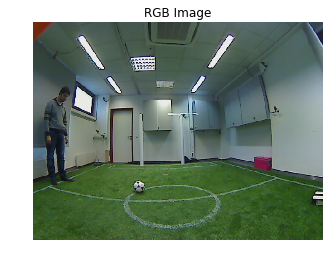

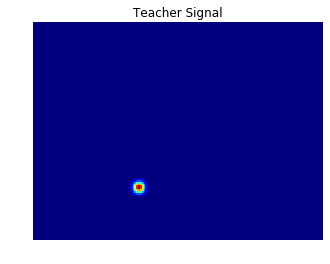

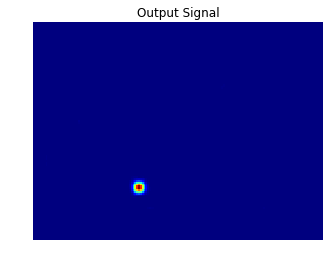

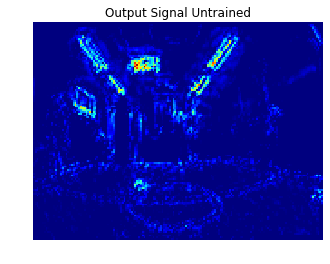

In [7]:
idx = 100

image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())

output = model(image.unsqueeze(0).float().to(device))
output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.axis('off')
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.savefig('rbgImage.jpg', bbox_inches='tight')
plt.show()

plt.title("Teacher Signal")
plt.axis('off')
plt.imshow(signal, cmap=cm.jet)
plt.savefig('teacher.jpg', bbox_inches='tight')
plt.show()


plt.title("Output Signal")
plt.axis('off')
plt.imshow(output_signal, cmap=cm.jet)
plt.savefig('output.jpg', bbox_inches='tight')
plt.show()


output = untrained(image.unsqueeze(0).float().to(device))
output_signal = np.array(output.cpu().squeeze().detach())

plt.title("Output Signal Untrained")
plt.axis('off')
plt.imshow(output_signal, cmap=cm.jet)
plt.savefig('output_untrained.jpg', bbox_inches='tight')
plt.show()


In [ ]:
epochs = 100

for epoch in range(epochs):
    epoch_loss = 0
    tic = time.time()
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()

        images = data['image'].float().to(device)
        signals = data['signal'].float().to(device)

        outputs = model(images)

        loss = criterion(signals, outputs)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
      torch.save(model.state_dict(), "epoch_{}.model".format(epoch + 1))
      
    epoch_loss /= len(trainset)
    epoch_time = time.time() - tic
    print("Epoch: {}, loss: {}, time: {:.5f} seconds".format(epoch + 1, epoch_loss, epoch_time))


Epoch: 1, loss: 7.884400637488775e-05, time: 70.29491 seconds
Epoch: 2, loss: 2.659762031814863e-07, time: 70.01427 seconds
Epoch: 3, loss: 2.5538954729177576e-07, time: 70.33460 seconds
Epoch: 4, loss: 2.5390032954796546e-07, time: 70.06711 seconds
Epoch: 5, loss: 2.5304113090142646e-07, time: 70.26629 seconds
Epoch: 6, loss: 2.527879550276649e-07, time: 69.59436 seconds
Epoch: 7, loss: 2.5258569241775215e-07, time: 69.88272 seconds
Epoch: 8, loss: 2.527757613656499e-07, time: 69.87045 seconds
Epoch: 9, loss: 2.523633809676362e-07, time: 69.88465 seconds
Epoch: 10, loss: 2.524514092129255e-07, time: 68.96054 seconds
Epoch: 11, loss: 2.526066881029426e-07, time: 69.06656 seconds
Epoch: 12, loss: 2.5229711948158205e-07, time: 69.55757 seconds
Epoch: 13, loss: 2.522680020364333e-07, time: 69.77070 seconds
Epoch: 14, loss: 2.522625916520976e-07, time: 69.68653 seconds
Epoch: 15, loss: 2.5225959996909874e-07, time: 69.54938 seconds
Epoch: 16, loss: 2.5225028064308325e-07, time: 69.73683 se

#### After training

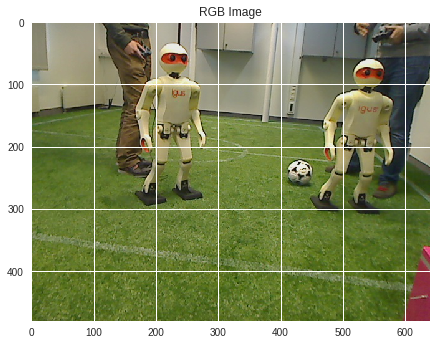

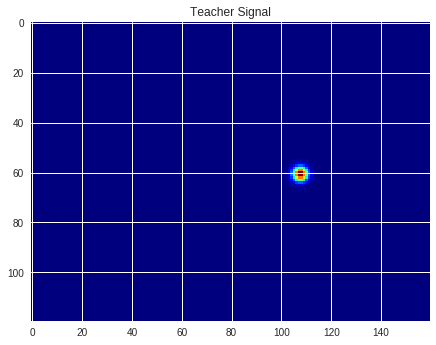

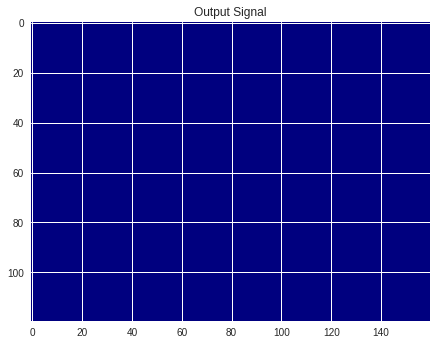

In [11]:
idx = 1000
image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())

output = model(image.unsqueeze(0).float().to(device))
output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal")
plt.imshow(output_signal, cmap=cm.jet)
plt.show()